In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2


In [2]:
train_df = pd.read_csv("../data/original_data/ais_train.csv", sep="|")

##### Heading feature

The direction of which the bow of the given vessel is pointing at the exact timestep, measured in degrees from 0 to 360.

Not influenced by drift, in contrast to COG. Default value is 511, indicating that heading was not available.

Ideas:

Need to insert value for heading where it is set to either 511 or 483 (default values indicating the heading could not be read)
- In instances where heading is missing but not COG -> Infer heading from COG (maybe not, these features do not seem to correlate massively)
- In instances where both heading and COG are missing -> Extrapolate 

In [3]:
train_df["heading"].head()

0     88
1    347
2    112
3    142
4    215
Name: heading, dtype: int64

In [4]:
max_heading = train_df[train_df["heading"] != 511]["heading"].max()
min_heading = train_df["heading"].min()
heading_count = train_df["heading"].count()
heading_unique_values_count = len(train_df["heading"].unique())

headings_above_max_heading = train_df[train_df["heading"] > 359]
unique_headings_above_max_heading = headings_above_max_heading["heading"].unique()
heading_values_above_max_count = len(headings_above_max_heading)
heading_abnormal_value_count = len(train_df[train_df["heading"] == 483])

heading_default_value_count = len(train_df[train_df["heading"] == 511])

heading_default_and_cog_default_count = len(train_df[(train_df["heading"] > 359) & (train_df["cog"] == 360)])

print(f"Max heading, excluding default value: {max_heading}")
print(f"Min heading: {min_heading}")
print(f"Count: {heading_count}")
print(f"Unique heading values: {heading_unique_values_count}")
print(f"Unique heading values above max heading: {unique_headings_above_max_heading}")
print(f"Heading values above max value count: {heading_values_above_max_count}")
print(f"Default heading value count: {heading_default_value_count}")
print(f"Count of entries where heading is 483: {heading_abnormal_value_count}")
print(f"Count of entries where both heading and cog are missing: {heading_default_and_cog_default_count}")

Max heading, excluding default value: 483
Min heading: 0
Count: 1522065
Unique heading values: 362
Unique heading values above max heading: [511 483]
Heading values above max value count: 4896
Default heading value count: 4895
Count of entries where heading is 483: 1
Count of entries where both heading and cog are missing: 1081


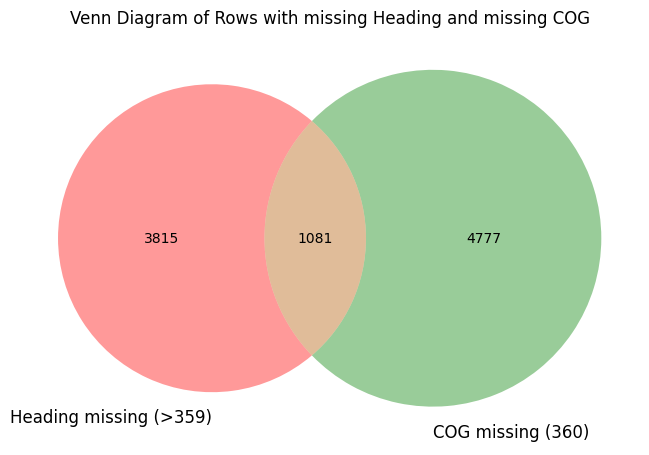

In [5]:
rows_where_heading_missing = set(train_df.index[train_df['heading'] > 359])
rows_where_cog_missing = set(train_df.index[train_df['cog'] == 360])

plt.figure(figsize=(8, 8))
venn2([rows_where_heading_missing, rows_where_cog_missing], set_labels=('Heading missing (>359)', 'COG missing (360)'))

plt.title("Venn Diagram of Rows with missing Heading and missing COG")
plt.show()

Chosen vessl ID: 61e9f3a8b937134a3c4bfdf7
['61e9f3a8b937134a3c4bfdf7']


<Figure size 1000x600 with 0 Axes>

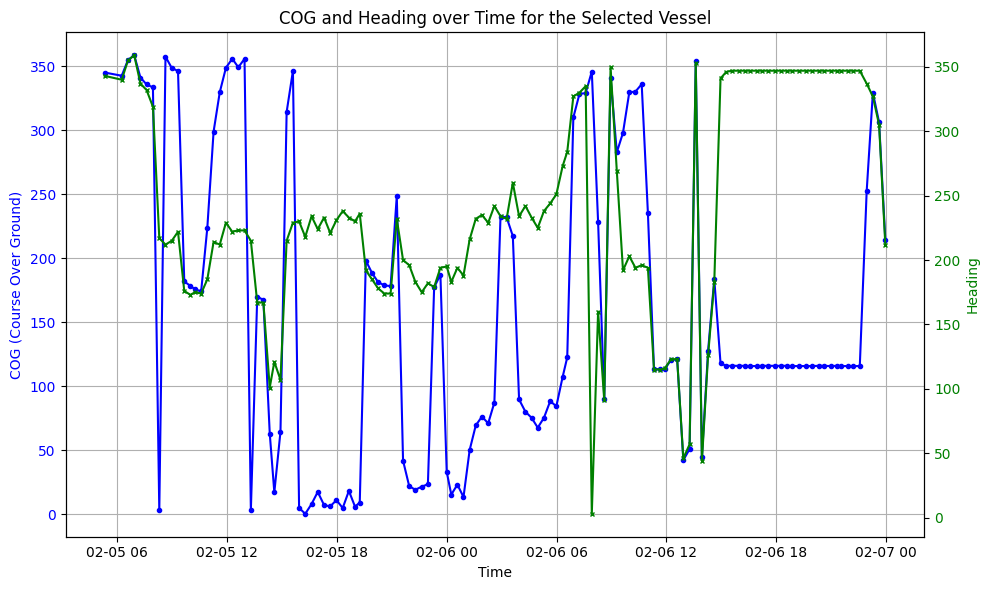

In [6]:
# Filter vessel IDs by whether they have valid heading and cog feature values in all timestamps
valid_vessel_ids = train_df.groupby('vesselId').filter(
    lambda group: (group['cog'] != 360).all() and (group['heading'] <= 359).all()
)['vesselId'].unique()

vessel_id = valid_vessel_ids[0]
print(f"Chosen vessl ID: {vessel_id}")

df_for_vessel = train_df[train_df["vesselId"] == vessel_id].copy()

print(df_for_vessel["vesselId"].unique())

df_for_vessel['time_converted'] = pd.to_datetime(df_for_vessel['time'], errors='coerce')

df_for_vessel_filtered = df_for_vessel[(df_for_vessel['time_converted'] < pd.to_datetime("2024-02-07")) & (df_for_vessel['time_converted'] > pd.to_datetime("2024-02-5"))]

plt.figure(figsize=(10, 6))
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot COG on the left y-axis
ax1.plot(df_for_vessel_filtered['time_converted'], df_for_vessel_filtered['cog'], marker='o', linestyle='-', markersize=3, color='b', label='COG')
ax1.set_xlabel('Time')
ax1.set_ylabel('COG (Course Over Ground)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Step 2: Create a second y-axis to plot Heading
ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis
ax2.plot(df_for_vessel_filtered['time_converted'], df_for_vessel_filtered['heading'], marker='x', linestyle='-', markersize=3, color='g', label='Heading')
ax2.set_ylabel('Heading', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add title and grid
plt.title('COG and Heading over Time for the Selected Vessel')
ax1.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

